# How a Bayesian Shops on Amazon
Alex Sanchez  
June 2020 // Seattle, WA
___

I was catching up with a friend over a drink one evening when the topic of conversation shifted to work. At the time, my friend was working at Amazon as a UX designer and was on a project related to how people interact with the reviews section of a product page. It's a very important part of buying a product on Amazon, but one that's full of noise. Any one review isn't useful on its own and carefully balancing what all the reviews have to say is more work than it's worth. He mentioned that people have different ways they distill the reviews in order to come to a decision; a heuristic that helps them choose one product over another. 

Some people only look at the number of 1-star reviews, some only the number of 5-stars. For me, I liked to add together the percentage of 4 and 5-stars and if it's above 90%, I feel confident in buying. Among all the different tricks people use, one interesting thing stands out: rarely, if ever, does anyone just go by the average rating. Why are we so adverse to using such a strait-forward indicator?

We may not know it, but we're being a little Bayesian in our reasoning for being skeptical of comparing the averages. There are many reasons for this, but the one I'd like to focus on in this article is that it's hard to compare a product which has hundreds of reviews with a product that might only have a few dozen. There's some uncertainty which comes with a product that has less reviews. Taken to the extreme, would you feel confident buying a product which had a perfect 5-start average if there was only one review? Probably not.

I hope to show that we can quantify this uncertainty to form a statistical comparison of two products even though the sample size of reviews is very different. We can even calculate a probability of one product having better reviews than another. Let's imagine we're comparing two printers. One printer, say Printer A,  has better reviews than Printer B, but much fewer of them. We can quantify the uncertainty that comes with less information (i.e. fewer reviews) and use Bayesian analysis to factor in this uncertainty in deciding if Printer A is really better than Printer B.




To do a Bayesian analysis we need to compute a probability distribution for each printer, then compare these two distributions to quantify how sure we are that one printer is better than the other. The distributions we're comparing are known as *posteriors* which show the probabilities for each set of parameters that may result in the data we observe. In this case, the parameters are the probabilities of seeing each star category (1 to 5 stars) for each printer and the data is the actual count of 1-star, 2-star, 3-star, 4-star and 5-star reviews each printer recieved.

To get the posterior for each printer I need to multiply two distrbutions together:
1. The likelihoods of seeing the **data** given the underlying parameters. This is often referred to as the "likelihood".
2. The likelihoods of seeing the underlying **parameters**, referred to as the "prior."

If we think back to Bayes' Rule we can see where each piece fits in:  

$\theta$ = parameters, $X$ = data  

$P(\theta \ | \ X) = \frac{P(X |\theta) \ \cdot \ P(\theta)}{P(X)}$ 

$P(\theta \ | \ X) \propto P(X \ | \ \theta) \cdot P(\theta)$  

Posterior $\propto$ Likelihood $\cdot$ Prior

In english: The Posterior is proportional to the Likelihood times the Prior.

First I must generate the parameters ( $\theta$ ) and in this case they are the parameters to the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution). The parameters of the multinomial distrubtion are the probabilties of each category and the total number of observations. For doing a Bayesian analysis, we need to consider all the possible multinomial distributions which could generate the data we see for each product review. This means generating all the possible combinations of five probabilities which add to 1.0 (e.g. [.25, .25, .25, .10, .15]). We do this with the code below and generate over 4.5 million combinations!

In [1]:
import matplotlib.pyplot as plt
from typing import Generator
import scipy.stats as stats
import pandas as pd
import numpy as np

In [2]:
def make_sums(n: int, total_sum: int) -> Generator[int, None, None]:
  """ 
  Return a generator of all positive integer permutations which add to the 
  supplied total_sum.

  Arguments:
  n -- the number of positive integers in each permutation
  total_sum -- what all the positive itegers should add up to
  """

  if n == 1:
    yield (total_sum,)
  else:
    for value in range(total_sum + 1):
      for permutation in make_sums(n - 1, total_sum - value):
        yield (value,) + permutation

In [3]:
l = list(make_sums(5,100))
parameters = np.array(l)/100

In [4]:
print('Total permutations:', len(parameters))
print('10 sample permutations:')
sample_idxs = np.random.choice(parameters.shape[0], 10)
print(parameters[sample_idxs, :])

Total permutations: 4598126
10 sample permutations:
[[0.1  0.43 0.06 0.38 0.03]
 [0.26 0.27 0.05 0.39 0.03]
 [0.14 0.17 0.05 0.52 0.12]
 [0.24 0.15 0.01 0.31 0.29]
 [0.73 0.03 0.02 0.17 0.05]
 [0.35 0.07 0.12 0.34 0.12]
 [0.03 0.14 0.17 0.21 0.45]
 [0.06 0.06 0.19 0.33 0.36]
 [0.32 0.1  0.14 0.09 0.35]
 [0.17 0.46 0.11 0.2  0.06]]


Now that we have our parameters ( $\theta$ ), we just need the data ( $X$ ). The data in this case are the counts for each star category for each printer. Amazon gives use the total number of reviews and the percentage for each star category which we can use to generate the raw data. 

In [5]:
data_a = round(pd.Series([.60, .10, .14, .16, .00]) * 40, 0).astype(int).to_list()
data_b = round(pd.Series([.52, .16, .10, .14, .08]) * 100, 0).astype(int).to_list()

print('Keyboard A star counts', data_a)
print('Keyboard B star counts', data_b)

Keyboard A star counts [24, 4, 6, 6, 0]
Keyboard B star counts [52, 16, 10, 14, 8]


In [6]:
print('Average rating of Printer A: ', np.dot(data_a, [5, 4, 3, 2, 1]) / 40, 'stars')
print('Average rating of Printer b: ', np.dot(data_b, [5, 4, 3, 2, 1]) / 100, 'stars')

Average rating of Printer A:  4.15 stars
Average rating of Printer b:  3.9 stars


Next, let's compute the relative likelihoods of seeing the data given the parameters (  $P( \ X \ | \ \theta$ \) ) for Printer A and B. Since we're getting a likelihood for each parameter 

In [7]:
likelihoods_a = stats.multinomial.pmf(x=data_a, n=sum(data_a), p=parameters)
likelihoods_b = stats.multinomial.pmf(x=data_b, n=sum(data_b), p=parameters)

Then we'll compute the priors. The prior distribution to the multinomial is the Dirichlet distribution. A sample from the Dirichlet distribution gives you a paramter $( \ \theta \ )$ for the multinomial distribution. In this case we will use a weak, uninformed prior (all parameters are equally likely).

In [8]:
# a weak, uninformed prior
dirichet = stats.dirichlet([1, 1, 1, 1, 1])

As we can see below, two random samples from our prior distribution are equally likey 

In [9]:
one_sample = dirichet.rvs(1)[0]
another_sample = dirichet.rvs(1)[0]

print('A random sample from our uninformed Dirichlet:', one_sample)
print('Another random sample from our uninformed Dirichlet:', another_sample)
print('*****')
print('Relative likelihood of first sample: ', dirichet.pdf(one_sample))
print('Relative likelihood of second sample: ', dirichet.pdf(another_sample))

A random sample from our uninformed Dirichlet: [0.22206545 0.68900469 0.0040924  0.04376135 0.04107611]
Another random sample from our uninformed Dirichlet: [0.23141917 0.23392925 0.39715255 0.03802998 0.09946905]
*****
Relative likelihood of first sample:  24.000000000000004
Relative likelihood of second sample:  24.000000000000004


In [10]:
priors = dirichet.pdf(parameters.T)

Now that we have the **likelihoods** and **priors**, we just need to multiply them together to get the **posterior**:

In [11]:
posterior_a = pd.Series( likelihoods_a * priors )
posterior_b = pd.Series( likelihoods_b * priors )

I will add one additional step and normalize each posterior by their sum. This will turn our relative lieklihoods into firm probabilities. If you look back at Bayes' Rule, this is the step where we divide by $P(X)$:

In [12]:
posterior_a = posterior_a / posterior_a.sum()
posterior_b = posterior_b / posterior_b.sum()

And now I'm done with the Bayesian part of the analysis. What I get are two probability distributions. One for Printer A and one for Printer B. So the probability of what? It's the posteror $P(\theta|X)$. In english, it's the probabilty that a set of parameters (probabilities of each star category) are the actual parameters given the data (reviews) we see. Another way of saying this is: we know that 60% of Printer A's reviews are 5-stars, but how sure are we that 60% is the true probability of Printer A getting a 5-star review given that we only have 40 reveiws to determine this. In addition to that, we have no prior knowledge about what Printer A's reviews might be like (our uninformed prior).

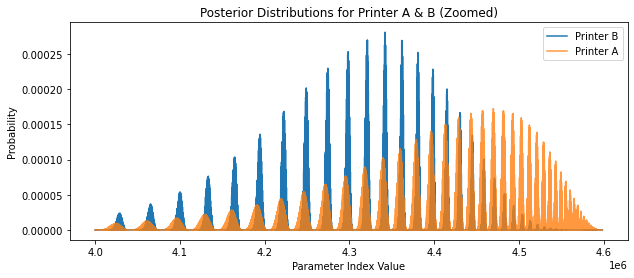

In [13]:
fig, ax = plt.subplots()

posterior_b.loc[4000000:].rename('Printer B').plot(title='Posterior Distributions for Printer A & B (Zoomed)', legend=True, ax=ax);
posterior_a.loc[4000000:].rename('Printer A').plot(legend=True, figsize=(10,4), ax=ax, alpha=.8);

ax.set_xlabel("Parameter Index Value");
ax.set_ylabel("Probability");

Unfortunately, our Bayesian analysis only gets us part of they way there. The chart above isn't very interptrable because the x-axis is just the index (0 - 4.6ish million) of each parameter set. Since each parameter has 5 categories to account for (1-star to 5-stars) that means we have 5 dimensions of data, which makes comparing the two printers' posteriors difficult. We could see which parameters are most likey for each distribution by just finding the maximum for each distribution (for a Dirichlet distribution this is called the "mean")

In [14]:
print('Most likely parameters for Printer A:', parameters[posterior_a.argmax()], f'p = {round(posterior_a.max(), 5)}')
print('Most likely parameters for Printer B:', parameters[posterior_b.argmax()], f'p = {round(posterior_b.max(), 5)}')

Most likely parameters for Printer A: [0.6  0.1  0.15 0.15 0.  ] p = 0.00017
Most likely parameters for Printer B: [0.52 0.16 0.1  0.14 0.08] p = 0.00028


Ok, I know this isn't telling us anything new, but I wanted to show how the posterior distributions work. The important thing is that we have a probability for each parameter set.

Luckily, our categories reflect a certian cardinality in the reviews and we can reduce them to one dimension by taking a mean. For example, [.30, .05, .35, .20, .10] can be converted to a 3.25 average by multplying it by [5, 4, 3, 2, 1] and then summing it up (this is the dot product in linear algebra).

In [15]:
np.array([.30, .05, .35, .20, .10]).dot([5, 4, 3, 2, 1])

3.25

In [16]:
# make a dataframe for each posterior that combine the parameters
# with the correspoding probabilities
posterior_a_avg = pd.concat([pd.DataFrame(parameters), posterior_a.rename('p')], axis=1)
posterior_b_avg = pd.concat([pd.DataFrame(parameters), posterior_b.rename('p')], axis=1)

# convert all of our parameters into averages and round to 2 decimal places
avg_index = round(posterior_a_avg.iloc[:, :5].dot([5,4,3,2,1]), 2)

# set the index as the corresponing parameter avg
posterior_a_avg = posterior_a_avg['p']
posterior_a_avg.index = avg_index
posterior_b_avg = posterior_b_avg['p']
posterior_b_avg.index = avg_index

# group by on the index and sum to combine duplicate avgs
posterior_a_avg = posterior_a_avg.groupby(level=0).sum()
posterior_b_avg = posterior_b_avg.groupby(level=0).sum()

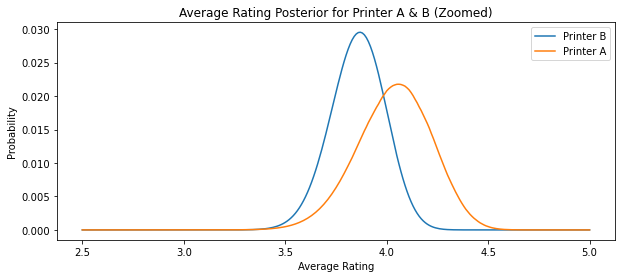

In [17]:
fig, ax = plt.subplots()

posterior_b_avg.rename('Printer B').loc[2.5:].plot(ax=ax, legend=True);
posterior_a_avg.rename('Printer A').loc[2.5:].plot(title='Average Rating Posterior for Printer A & B (Zoomed)', 
                                          ax=ax,
                                          legend=True,
                                          figsize=(10,4))

ax.set_xlabel("Average Rating");
ax.set_ylabel("Probability");

A thing of beauty, isn't it? The peak of each posterior represents the most likely average rating while the spread of the curve (variance) represents the uncertaintly. Since we have more reviews for Printer B, we are more certain of its true average rating. The last thing we have left to do is compute the probability that Printer A is better than Printer B.

To find this probability we need to compute the joint probability of both posteriors then sum all the probabilities in the area where A's rating is greater than B's. This gets a little tricky because we have to compute probabilities for all the possible combinations of A and B's average rating. This means that our joint probability will actually be a three dimensional curve where the x-axis is the average rating for Printer A, the y-axis is the average rating for printer B and z-axis is the joint probability.

In [18]:
# a lot going on here. note that B is transposed in line 7; creating an alignment for 
# all possible outcomes when A and B are multiplied
a_joint = pd.DataFrame([posterior_a_avg.to_list()]*posterior_a_avg.shape[0])
b_joint = pd.DataFrame([posterior_b_avg.to_list()]*posterior_b_avg.shape[0])

# assuming independence
joint_probability =  a_joint * b_joint.T

# normailze our joint distribution so all possible outcomes sum to 1
joint_probability = joint_probability / joint_probability.sum().sum()

The joint probability distribution for Keyboard A and B's average rating visualized in three dimensions:

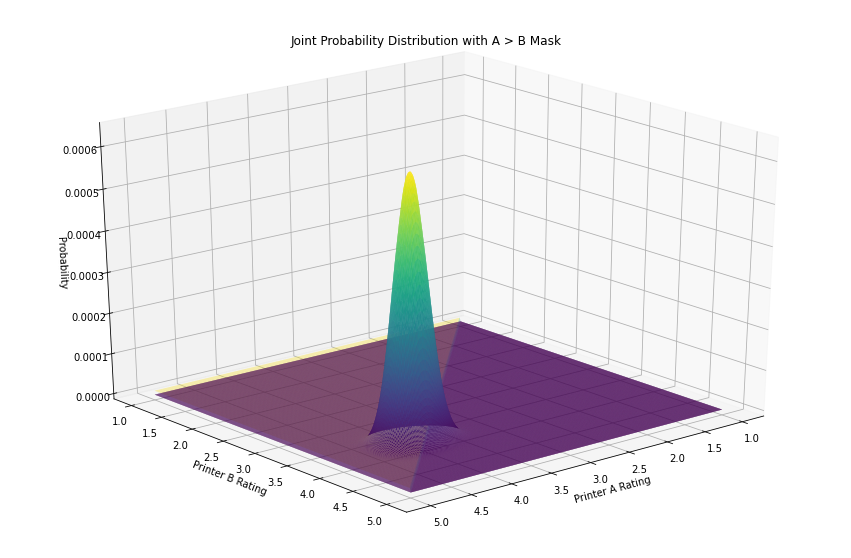

In [19]:
# visualizing the joint distribution with the A > B mask
fig, ax = plt.subplots(figsize=(15,10))

# create the necessary X, Y values
X, Y = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))

# create the Z values for the mask
# in this case a slight step in the 3d plot
a_gt_b_mask_plt = np.zeros(shape=X.shape)
a_gt_b_mask_plt[np.where(X > Y)] = .00001

ax = plt.axes(projection='3d')

# joint probability plot
ax.plot_surface(X, Y, joint_probability.values, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=1);

# mask plot
ax.plot_surface(X, Y, a_gt_b_mask_plt, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=.4);

ax.set_title('Joint Probability Distribution with A > B Mask');
ax.set_xlabel("Printer A Rating");
ax.set_ylabel("Printer B Rating");
ax.set_zlabel("Probability");

elevation = 25
azimuth = 50
ax.view_init(elevation, azimuth)

In the plot above, we see the joint distribution in all three dimensions. The half of the floor which is shaded lighter represents the area where Printer A's average rating is greater than Printer B's. Most of the joint probability distribution falls in this area which tells us Printer A is probably better than Printer B even though it has more uncertainty.

Below, I will compute the actual probability

In [20]:
# create a mask to filter out all scenarios where A's ratings are less than B's
# some of this was defined above, but I'm doing it again for clarity
ratings_A, ratings_B = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))
a_gt_b_mask = np.zeros(shape=X.shape)
a_gt_b_mask[np.where(ratings_A > ratings_B)] = 1.0

In [21]:
# apply the mask to our joint probability; leaving us only with probabilities
# where A > B then add them up to determine the final probability
p = (a_gt_b_mask * joint_probability).sum().sum()
print('Probability that Printer A has better ratings than Printer B:', round(p, 4))

Probability that Printer A has better ratings than Printer B: 0.7791


Using Bayesian analysis and some statisitcs I've been able to show that--even though we have some uncertaintly about Printer A (it has 60% less reviews)--we have justification in choosing it over Printer B because we are 77.9% sure that it's a better printer. 

That is how a Bayesian shops on Amazon.

### A Note On Choosing The Prior
There is some subjectivity in this analysis and Bayesian analysis in general. One criticism you could make is that I chose too weak of a prior ( Dirichlet(1, 1, 1, 1, 1) ). This might be appropriate if we don't know anything about how people rate items on Amazon (a 1-star is just as likely as a 5-star rating), but we actually do and we can use that knowledge to make a better prior. For example, Printer A has no 1-star reviews. It could be that Printer A is so good that it will never get one *or* it could be because we haven't yet heard back from enough people for one or more to eventually occur. Having a prior of 1 makes it very easy for Printer A to overcome the possibility of the latter. 

A way to fix this is to choose a prior based on previous reviews for other popular printers. This prior would take into consideration that no matter how good a printer is, it's bound to get some 1-star reviews for whatever reason. This would create more of a handicap for Printer A's smaller review count and would reduce its probability of being a better printer.

Let's say we take the average rating counts of the four most popular printers on Amazon and use the mean as our new prior (I just made these reviews up for the sake of illustration):

In [22]:
printer_1 = round(pd.Series([.69, .12, .06, .07, .12]) * 1245, 0).astype(int)
printer_2 = round(pd.Series([.70, .12, .06, .05, .11]) * 899, 0).astype(int)
printer_3 = round(pd.Series([.66, .16, .07, .05, .07]) * 500, 0).astype(int)
printer_4 = round(pd.Series([.74, .12, .07, .05, .06]) * 480, 0).astype(int)

stronger_prior = ((printer_1 + printer_2 + printer_3 + printer_4) / 4).to_list()
print('New prior parameters:', stronger_prior)

New prior parameters: [543.25, 98.75, 49.5, 45.25, 78.0]


In [23]:
new_dirichlet = stats.dirichlet(stronger_prior)
new_priors = new_dirichlet.pdf(parameters.T)

posterior_a = pd.Series( likelihoods_a * new_priors )
posterior_b = pd.Series( likelihoods_b * new_priors )
posterior_a = posterior_a / posterior_a.sum()
posterior_b = posterior_b / posterior_b.sum()

posterior_a_avg = pd.concat([pd.DataFrame(parameters), posterior_a.rename('p')], axis=1)
posterior_b_avg = pd.concat([pd.DataFrame(parameters), posterior_b.rename('p')], axis=1)

avg_index = round(posterior_a_avg.iloc[:, :5].dot([5,4,3,2,1]), 2)

posterior_a_avg = posterior_a_avg['p']
posterior_a_avg.index = avg_index
posterior_b_avg = posterior_b_avg['p']
posterior_b_avg.index = avg_index

posterior_a_avg = posterior_a_avg.groupby(level=0).sum()
posterior_b_avg = posterior_b_avg.groupby(level=0).sum()

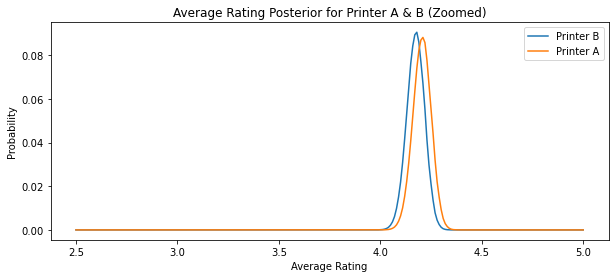

In [24]:
fig, ax = plt.subplots()

posterior_b_avg.rename('Printer B').loc[2.5:5].plot(ax=ax, legend=True);
posterior_a_avg.rename('Printer A').loc[2.5:5].plot(title='Average Rating Posterior for Printer A & B (Zoomed)', 
                                                     ax=ax,
                                                     legend=True,
                                                     figsize=(10,4))

ax.set_xlabel("Average Rating");
ax.set_ylabel("Probability");

In the graph above, we notice that our posteriors are spikier and thus more certain than before. This comes from using a stronger prior. Having more information going into our analysis can make the results of it more certain.

In [25]:
a_joint = pd.DataFrame([posterior_a_avg.to_list()]*posterior_a_avg.shape[0])
b_joint = pd.DataFrame([posterior_b_avg.to_list()]*posterior_b_avg.shape[0])

joint_probability =  a_joint * b_joint.T

joint_probability = joint_probability / joint_probability.sum().sum()

ratings_A, ratings_B = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))
a_gt_b_mask = np.zeros(shape=X.shape)
a_gt_b_mask[np.where(ratings_A > ratings_B)] = 1.0

p = (a_gt_b_mask * joint_probability).sum().sum()
print('Probability that Printer A has better reviews than Printer B:', round(p, 4))

Probability that Printer A has better reviews than Printer B: 0.6597


Printer A still has a higher probability of being a better printer, but much less so now. It's important we see that our choice of a different prior distribution had a significant impact on the results of our analysis. It should always be done thoughtfully and made explicit so everyone has a better context for the results.

Below, I have included a 3-D graph of the joint probability distribution as well for comparison. You can see that the differences are analagous to the differences we saw in the posterior distributions:

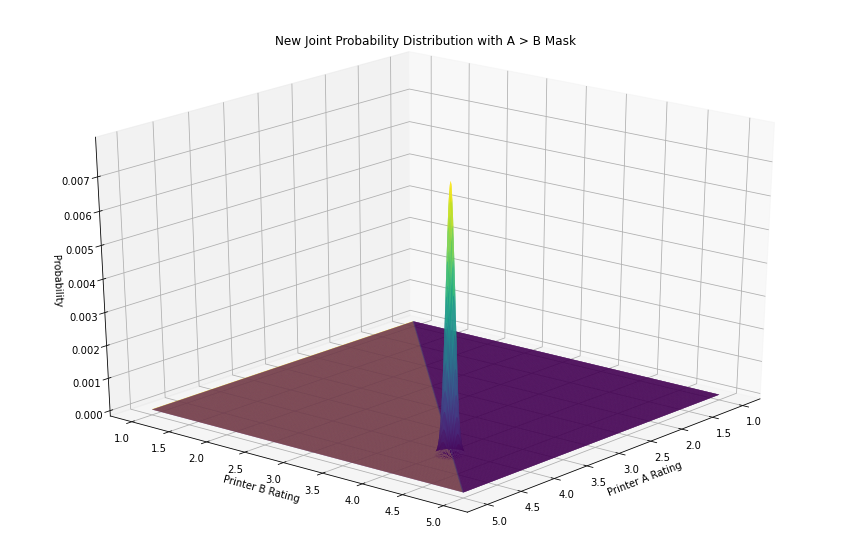

In [26]:
fig, ax = plt.subplots(figsize=(15,10))

X, Y = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))

a_gt_b_mask_plt = np.zeros(shape=X.shape)
a_gt_b_mask_plt[np.where(X > Y)] = .00001

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, joint_probability.values, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');

ax.plot_surface(X, Y, a_gt_b_mask_plt, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');

ax.set_title('New Joint Probability Distribution with A > B Mask');
ax.set_xlabel("Printer A Rating");
ax.set_ylabel("Printer B Rating");
ax.set_zlabel("Probability");

elevation = 25
azimuth = 40
ax.view_init(elevation, azimuth)